This notebook plots many metrics to compare the ML and exp algorithms.

For every plot below, $\text{Error} = \sqrt{\sum_i \, (z_i^{pred} - z_i^{true})^2}$, where $z_i$ are zernike coefficients in units of arcseconds.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth


In [2]:
def calculate_error(pred, truth):
    err = np.sqrt(np.sum(np.square((pred - truth)), axis=-1))
    err[~np.isfinite(err)] = np.inf
    return err


In [3]:
df = pd.read_pickle("data/test_dataframe.pkl")
zk = np.load("data/zk_predictions.npz", allow_pickle=True)

# put it all in a dictionary
zk = {key: zk[key] for key in zk.keys()}
zk["ml"] = (zk["mlIntra"] + zk["mlExtra"]) / 2

# fix the truth array
zk["truth"] = np.array([z for z in zk["truth"]])

# convert everything to arcseconds
for key, val in zk.items():
    if key != "pairs":
        zk[key] = convertZernikesToPsfWidth(val)

# also load the distribution of atmospheric errors
atm_err_per_zk = np.load("data/atm_errs.npy")
atm_err_tot = np.sqrt(np.sum(np.square(atm_err_per_zk), axis=1))


In [4]:
# create a dataframe with all the info we want to plot
errs = pd.DataFrame()
errs["intraIdx"] = zk["pairs"][:, 0]
errs["extraIdx"] = zk["pairs"][:, 1]
errs["corner"] = df.loc[errs["intraIdx"]]["corner"].to_list()
errs["filter"] = df.loc[errs["intraIdx"]]["filter"].to_list()
errs["seeing"] = df.loc[errs["intraIdx"]]["seeing"].to_list()
errs["airmass"] = df.loc[errs["intraIdx"]]["airmass"].to_list()
errs["intraAngle"] = np.sqrt(
    df.loc[errs["intraIdx"]]["fx"] ** 2 + df.loc[errs["intraIdx"]]["fy"] ** 2
).to_numpy()

errs["vignetting"] = [
    "Mirror vignetting" if angle < 1.74 else "Camera vignetting"
    for angle in errs["intraAngle"]
]

# total blends from intra + extra
blendDmag = df["blendMags"] - df["mag"]
errs["nBrightBlends"] = (
    blendDmag.loc[errs["intraIdx"]].apply(lambda arr: np.sum(arr < 2)).to_numpy()
    + blendDmag.loc[errs["extraIdx"]].apply(lambda arr: np.sum(arr < 2)).to_numpy()
).astype(int)

errs["nFaintBlends<1"] = (
    blendDmag.loc[errs["intraIdx"]].apply(lambda arr: np.sum(arr < 3)).to_numpy()
    + blendDmag.loc[errs["extraIdx"]].apply(lambda arr: np.sum(arr < 3)).to_numpy()
).astype(int) - errs["nBrightBlends"]

errs["nFaintBlends>1"] = (
    blendDmag.loc[errs["intraIdx"]].apply(lambda arr: np.sum(arr > 3)).to_numpy()
    + blendDmag.loc[errs["extraIdx"]].apply(lambda arr: np.sum(arr > 3)).to_numpy()
).astype(int)

# calculate the minimum distance to a bright blend
minDist = []
for idx in errs.index:
    dist = np.sqrt(
        np.sum(
            np.square(
                np.hstack(
                    (
                        df.loc[errs["intraIdx"][idx]]["brightBlendOffsets"],
                        df.loc[errs["extraIdx"][idx]]["brightBlendOffsets"],
                    )
                )
            ),
            axis=0,
        )
    )

    if dist.size == 0:
        minDist.append(np.inf)
    else:
        minDist.append(dist.min())
errs["minBrightDist"] = minDist

# minimum SNR in the pair
donut_radius = 62  # pixels
obscuration = 0.61  # fractional
donut_area = np.pi * donut_radius**2 * (1 - obscuration**2)
pixel_scale = 0.2


skyMag = df.loc[errs["intraIdx"]]["skyBrightness"].to_numpy()
skyMag -= 2.5 * np.log10(pixel_scale**2)
maxMag = np.max(
    [
        df.loc[errs["intraIdx"]]["mag"].to_numpy(),
        df.loc[errs["intraIdx"]]["mag"].to_numpy(),
    ],
    axis=0,
)
maxMag += 2.5 * np.log10(donut_area)
snr = 10 ** ((maxMag - skyMag) / (-2.5)) * np.sqrt(donut_area)
errs["snr"] = snr

# save errors in arcseconds
errs["exp"] = calculate_error(zk["exp"], zk["truth"])
errs["ml"] = calculate_error(zk["ml"], zk["truth"])


In [33]:
def clean_errs(
    maxBlends=0,
    minBrightDist=88,
    maxAngle=1.74,
    maxErr=np.inf,
):
    data = errs.copy()
    data = data[
        (data["nBrightBlends"] <= maxBlends)
        & (data["minBrightDist"] > minBrightDist)
        & (data["intraAngle"] < maxAngle)
        & (data["exp"] <= maxErr)
    ]
    return data


def group_errs(group, upperLim=None, maxErr=np.inf):
    data = clean_errs(
        maxBlends=np.inf if group == "nBrightBlends" else 0,
        minBrightDist=0 if group == "nBrightBlends" else 88,
        maxAngle=np.inf if group == "vignetting" else 1.74,
        maxErr=maxErr,
    )

    if upperLim is not None:
        data[group].clip(None, upperLim, inplace=True)

    keys, exp_vals = map(list, zip(*data.groupby(group)["exp"].apply(list).items()))
    keys, ml_vals = map(list, zip(*data.groupby(group)["ml"].apply(list).items()))

    if group == "filter":
        exp_vals = [exp_vals[keys.index(key)] for key in "ugrizy" if key in keys]
        ml_vals = [ml_vals[keys.index(key)] for key in "ugrizy" if key in keys]
        keys = [key for key in "ugrizy" if key in keys]

    if upperLim is not None:
        keys[-1] = str(keys[-1]) + "+"

    return keys, exp_vals, ml_vals


def plot_violins(
    group,
    xlabel,
    upperLim=None,
    norm=False,
):
    keys, exp_vals, ml_vals = group_errs(group, upperLim, maxErr=2)
    exp_med = np.array([np.median(vals) for vals in exp_vals])
    ml_med = np.array([np.median(vals) for vals in ml_vals])

    if norm:
        exp_vals = [vals / exp_med[0] for vals in exp_vals]
        exp_med /= exp_med[0]
        ml_vals = [vals / ml_med[0] for vals in ml_vals]
        ml_med /= ml_med[0]

    fig, (ax, leg) = plt.subplots(
        1,
        2,
        figsize=(7, 3),
        dpi=150,
        gridspec_kw={"width_ratios": [8, 1]},
        constrained_layout=True,
    )

    # create a violin plot of the errors per-sensor
    positions = np.arange(1, len(keys) + 1)
    ax.violinplot(exp_vals, positions=positions + 0.15, widths=0.25)
    ax.violinplot(ml_vals, positions=positions - 0.15, widths=0.25)

    # plot the medians as stars
    ax.scatter(positions + 0.15, exp_med, marker="*", s=60)
    ax.scatter(positions - 0.15, ml_med, marker="*", s=60)

    # setup labels
    ax.set(
        xlabel=xlabel,
        xticks=positions,
        xticklabels=keys,
        ylabel="Error (arcsec)",
    )
    ax.xaxis.labelpad = 7
    ax.tick_params(axis="x", length=0)

    # silver lines between panels
    for i in positions[:-1]:
        ax.axvline(i + 0.5, c="silver", ls="-", lw=0.4, zorder=0)

    # create the legend
    leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="TIE")
    leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="DL")
    leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    leg.axis("off")

    return fig, (ax, leg)


def plot_hists(group, title=None, upperLim=None, bins="auto", xmax=1, density=True):
    keys, exp_vals, ml_vals = group_errs(group, upperLim)

    fig, axes = plt.subplots(
        1,
        2,
        figsize=(7, 3),
        dpi=150,
        constrained_layout=True,
    )

    hist_settings = {
        "bins": bins,
        "range": (0, xmax),
        "histtype": "step",
        "alpha": 0.65,
        "density": density,
    }

    for key, vals in zip(keys, exp_vals):
        axes[0].hist(vals, **hist_settings, label=key)
    for key, vals in zip(keys, ml_vals):
        axes[1].hist(vals, **hist_settings, label=key)

    axes[1].legend(title=title)
    axes[0].set(ylabel="Density", xlabel="Error (arcseconds)", title="TIE")
    axes[1].set(xlabel="Error (arcseconds)", title="DL")

    return fig, axes


## 0: Zernike example plot

Check these numbers match: 18421 18420 [6644 6639]


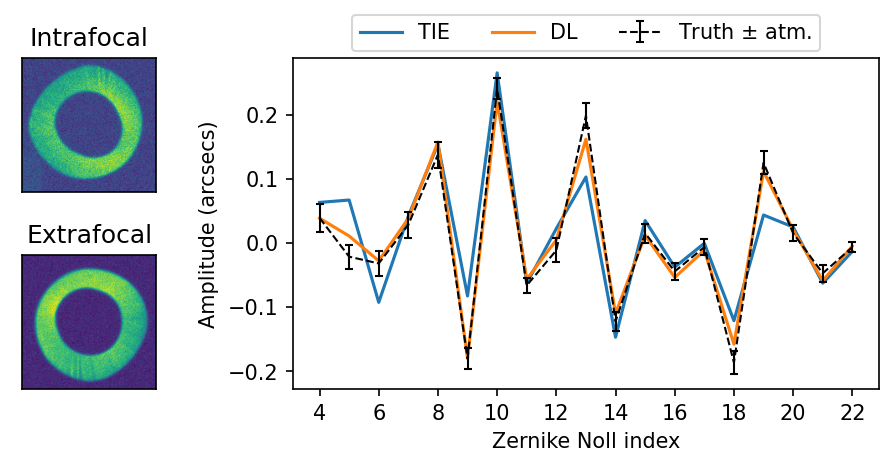

In [114]:
data = clean_errs()

idx = np.abs(data["ml"] - np.median(atm_err_tot) + 0.0013).argmin()
intraIdx, extraIdx = data.iloc[idx][["intraIdx", "extraIdx"]]
print("Check these numbers match:", intraIdx, extraIdx, zk["pairs"][idx])

fig, axes = plt.subplot_mosaic(
    """
    accc
    bccc
    """,
    constrained_layout=True,
    figsize=(6, 3),
    dpi=150,
)

axes["a"].imshow(df["image"].loc[intraIdx], origin="lower")
axes["a"].set(xticks=[], yticks=[], title="Intrafocal")

axes["b"].imshow(df["image"].loc[extraIdx], origin="lower")
axes["b"].set(xticks=[], yticks=[], title="Extrafocal")


idx = np.where(zk["pairs"] == [intraIdx, extraIdx])[0][0]
zk_grid = np.arange(4, 23)
axes["c"].errorbar(
    zk_grid,
    zk["truth"][idx],
    yerr=np.median(atm_err_per_zk, axis=0),
    c="k",
    capsize=2,
    lw=1,
    ls="--",
    label="Truth $\pm$ atm.",
    zorder=10,
)
axes["c"].plot(zk_grid, zk["exp"][idx], label="TIE")
axes["c"].plot(zk_grid, zk["ml"][idx], label="DL")
axes["c"].set(
    xlabel="Zernike Noll index",
    ylabel="Amplitude (arcsecs)",
    xticks=np.arange(4, 23, 2),
)
axes["c"].legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower center", borderaxespad=0, ncol=3
)

fig.savefig("figures/zk_example.pdf")
plt.show()


## 1. Check that ML is fine with only intra/extra

In [22]:
intraPairs = []
extraPairs = []
for (pntId, corner, intra), group in df.groupby(["pntId", "corner", "intra"]):
    if len(group) > 1:
        sorted = group.sort_values("mag")
        index = sorted.index.to_numpy()
        npairs = len(sorted) // 2
        idx_pairs = index[: 2 * npairs].reshape(npairs, 2).tolist()
        if intra:
            intraPairs.extend(idx_pairs)
        else:
            extraPairs.extend(idx_pairs)

intraPairs = np.array(intraPairs)
extraPairs = np.array(extraPairs)

intraIdx = np.abs(zk["pairs"][:, 0][:, None] - intraPairs.flatten()[None, :]).argmin(
    axis=0
)
extraIdx = np.abs(zk["pairs"][:, 1][:, None] - extraPairs.flatten()[None, :]).argmin(
    axis=0
)

intra_pair_err = calculate_error(
    zk["mlIntra"][intraIdx].reshape(-1, 2, 19).mean(axis=1),
    zk["truth"][intraIdx].reshape(-1, 2, 19).mean(axis=1),
)

extra_pair_err = calculate_error(
    zk["mlExtra"][extraIdx].reshape(-1, 2, 19).mean(axis=1),
    zk["truth"][extraIdx].reshape(-1, 2, 19).mean(axis=1),
)


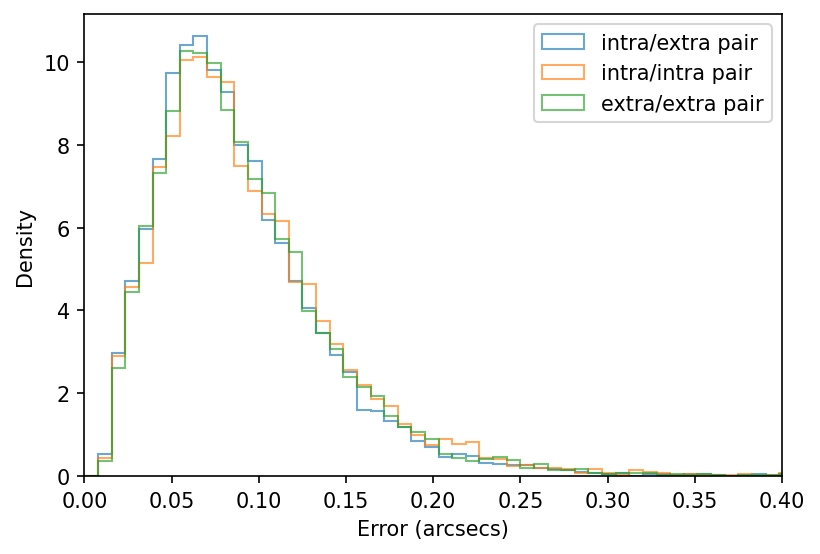

In [26]:
hist_settings = {
    "bins": 64,
    "range": (0, 0.50),
    "histtype": "step",
    "alpha": 0.65,
    "density": True,
}

# now comparing intra, extra, both
fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
ax.hist(errs["ml"], **hist_settings, label="intra/extra pair")
ax.hist(intra_pair_err, **hist_settings, label="intra/intra pair")
ax.hist(extra_pair_err, **hist_settings, label="extra/extra pair")
ax.legend()
ax.set(xlabel="Error (arcsecs)", ylabel="Density", xlim=(0, 0.40))

fig.savefig("figures/dl_intra_vs_extra_pairs.pdf")

plt.show()


## 2. Compare DL to exp

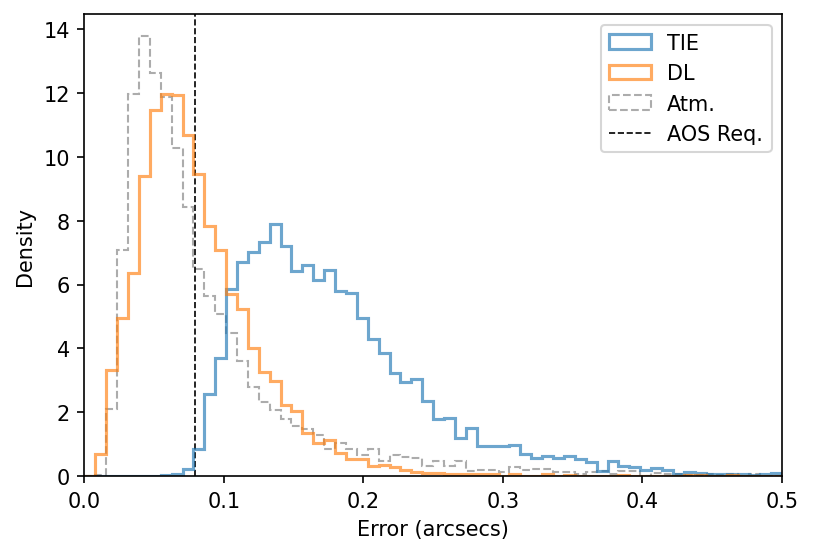

Atm median: 0.06661929630731217
TIE median: 0.16653413058379007
ML median: 0.07302112393928412
TIE/ML: 2.280629516498
Fraction of ML below AOS requirement: 0.5635618043350908


In [24]:
hist_settings = {
    "bins": 64,
    "range": (0, 0.5),
    "histtype": "step",
    "alpha": 0.65,
    "density": True,
}


fig, ax = plt.subplots(dpi=150, figsize=(6, 4))

# plot ml vs exp for the ideal case
data = clean_errs()
ax.hist(data["exp"], **hist_settings, lw=1.5, label="TIE")
ax.hist(data["ml"], **hist_settings, lw=1.5, label="DL")
ax.hist(
    atm_err_tot,
    **hist_settings,
    color="gray",
    ls="--",
    lw=1,
    zorder=0,
    label="Atm.",
)
ax.axvline(0.079, c="k", ls="--", lw=0.8, zorder=0, label="AOS Req.")
ax.set(xlabel="Error (arcsecs)", ylabel="Density", xlim=hist_settings["range"])
ax.legend()

fig.savefig("figures/ideal_tie_vs_ml.pdf")

plt.show()
print("Atm median:", np.nanmedian(atm_err_tot))
print("TIE median:", np.median(data["exp"]))
print("ML median:", np.median(data["ml"]))
print("TIE/ML:", np.median(data["exp"]) / np.median(data["ml"]))

print("Fraction of ML below AOS requirement:", np.mean(data["ml"] < 0.079))


## 3. Error per sensor

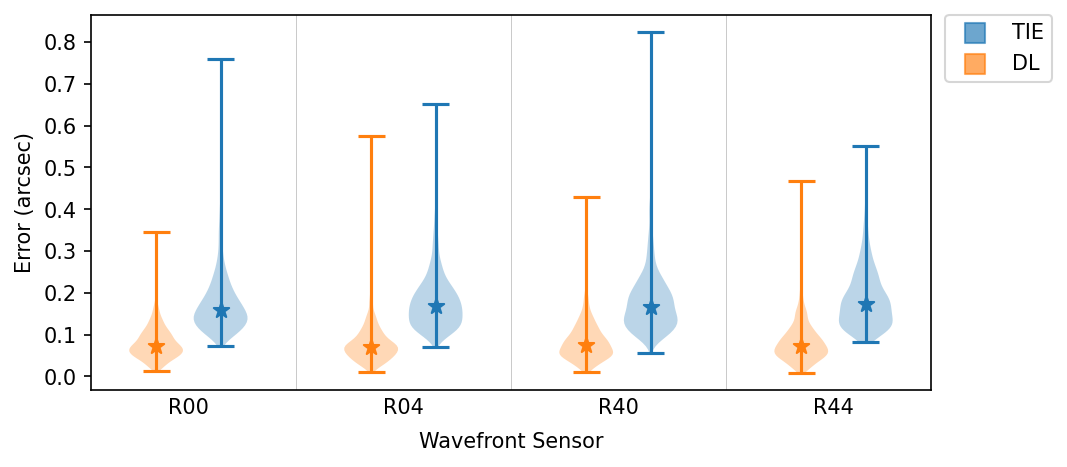

In [271]:
fig, ax = plot_violins("corner", "Wavefront Sensor")
fig.savefig("figures/sensor_violin.pdf")


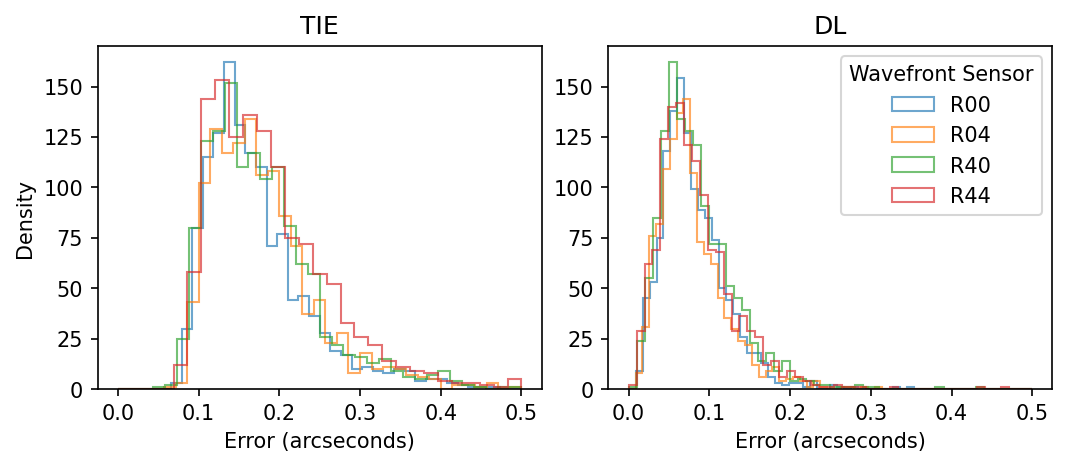

In [28]:
fig, axes = plot_hists("corner", "Wavefront Sensor", xmax=0.5)
fig.savefig("figures/sensor_hist.pdf")


## 4. Error per filter

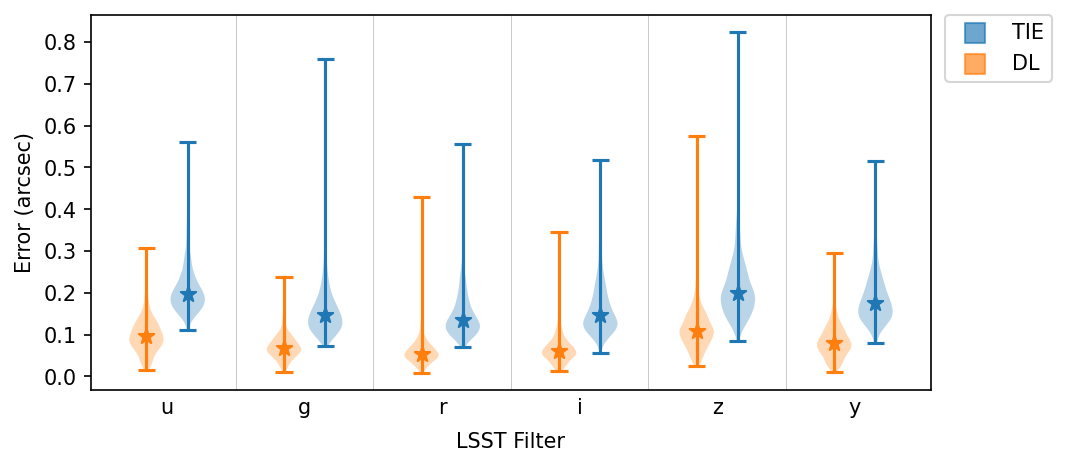

In [273]:
fig, ax = plot_violins("filter", "LSST Filter")
fig.savefig("figures/filter_violin.pdf")


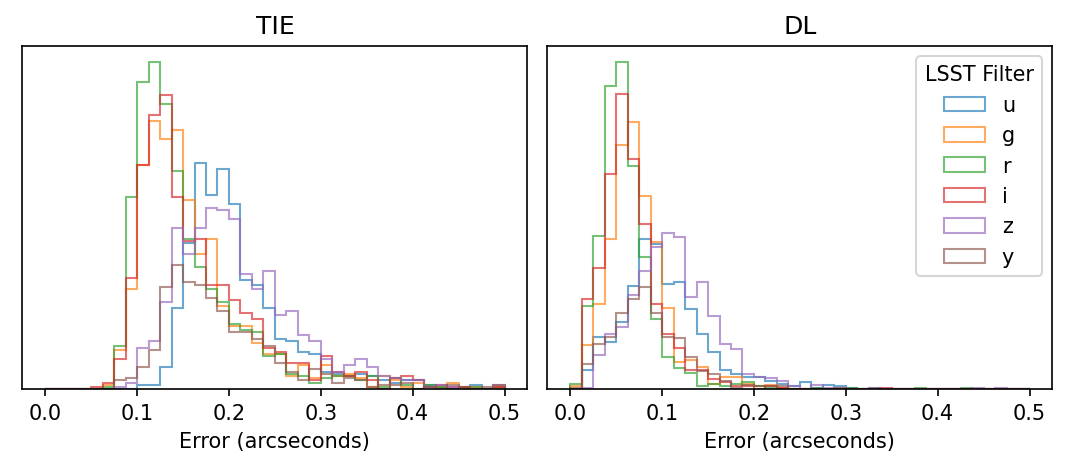

In [274]:
fig, axes = plot_hists("filter", "LSST Filter", bins=40, xmax=0.5)
fig.savefig("figures/filter_hist.pdf")


## 5. Vignetting

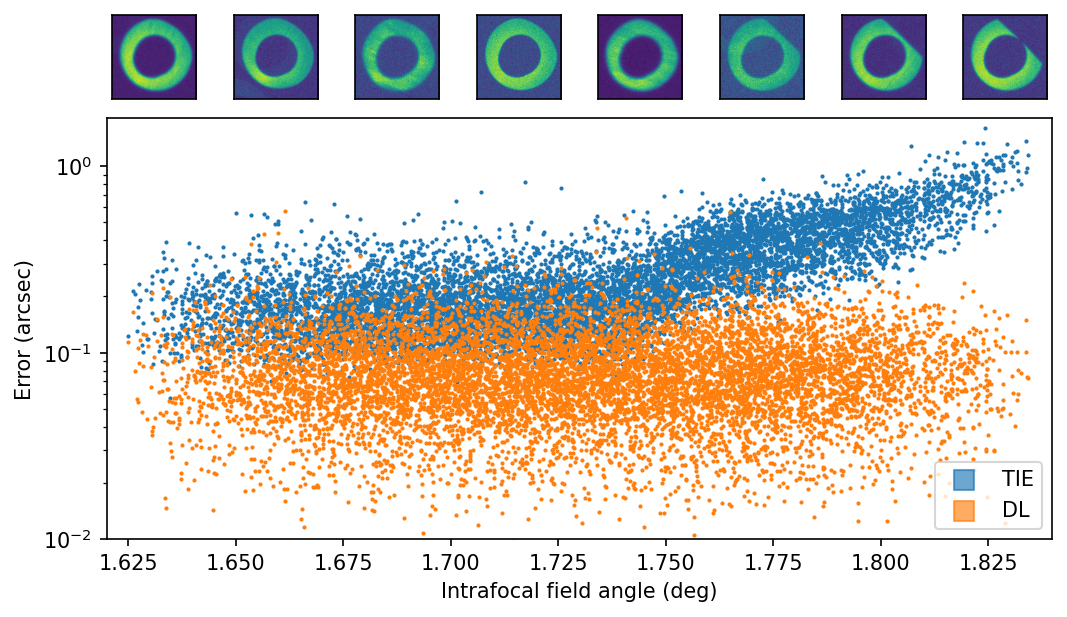

In [275]:
fig, axes = plt.subplot_mosaic(
    """
    abcdefgh
    zzzzzzzz
    zzzzzzzz
    zzzzzzzz
    zzzzzzzz
    zzzzzzzz
    """,
    figsize=(7, 4),
    dpi=150,
    constrained_layout=True,
)

data = clean_errs(maxAngle=np.inf)


# write a function for plotting images above angles
def plot_img(ax, angle, nrot):
    # identify the closest star
    idx = np.argmin(np.abs(data["intraAngle"] - angle))
    intraIdx = data.iloc[idx]["intraIdx"]
    img = df.loc[intraIdx]["image"]

    # rotate the image nrot times
    for i in range(nrot):
        img = np.rot90(img)

    # plot the image
    ax.imshow(img, origin="lower")
    ax.set(xticks=[], yticks=[])


# plot images at a range of different angles
cutouts = {
    "a": [1.6320, 2],
    "b": [1.6600, 3],
    "c": [1.6911, 1],
    "d": [1.7160, 3],
    "e": [1.7460, 1],
    "f": [1.7729, 2],
    "g": [1.8005, 0],
    "h": [1.8307, 3],
}
for key, vals in cutouts.items():
    plot_img(axes[key], *vals)

axes["z"].scatter(data["intraAngle"], data["exp"], s=1, rasterized=True)
axes["z"].scatter(data["intraAngle"], data["ml"], s=1, rasterized=True)

# labels
axes["z"].set(
    xlabel="Intrafocal field angle (deg)",
    ylabel="Error (arcsec)",
    yscale="log",
    xlim=(1.62, 1.84),
    ylim=(1e-2, 1.8),
)
axes["z"].scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="TIE")
axes["z"].scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="DL")
axes["z"].legend(loc="lower right")

fig.savefig("figures/vignetting_scatter.pdf")
plt.show()


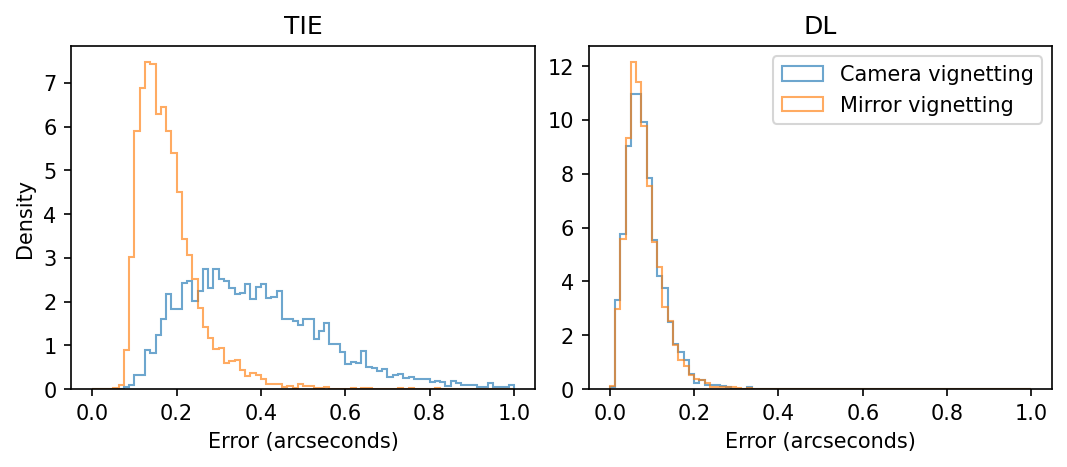

In [34]:
fig, axes = plot_hists("vignetting", bins=80)
fig.savefig("figures/vignetting_hist.pdf")


## 6. Bright Blends

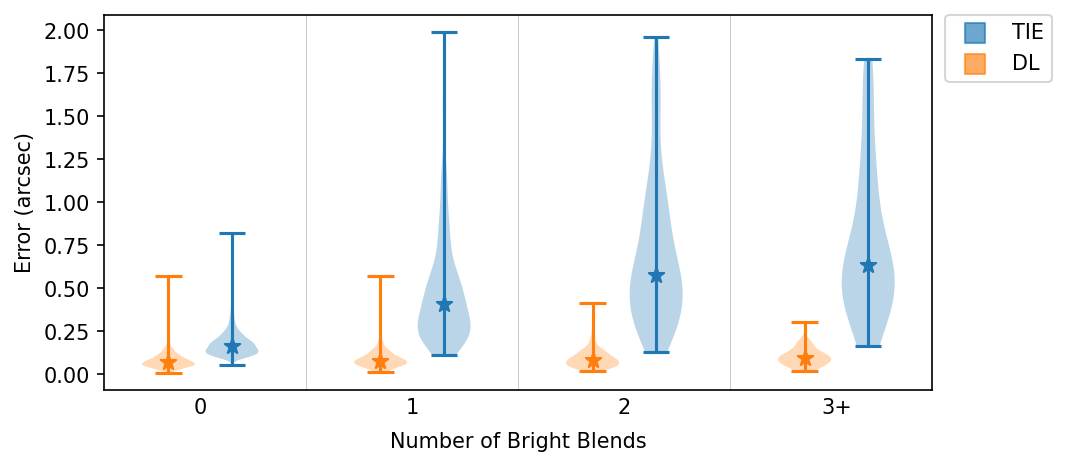

In [277]:
fig, ax = plot_violins("nBrightBlends", "Number of Bright Blends", upperLim=3)
fig.savefig("figures/bright_blend_violin.pdf")


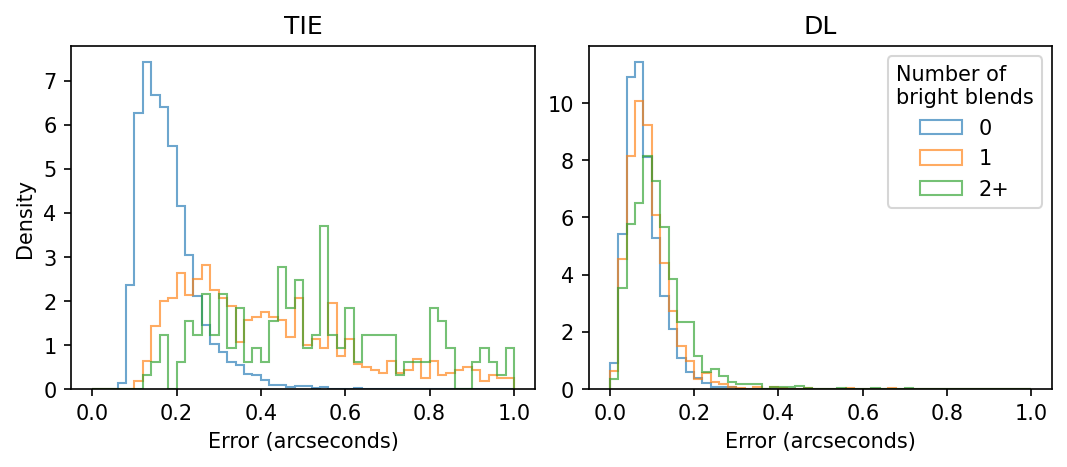

In [36]:
fig, axes = plot_hists(
    "nBrightBlends", "Number of\nbright blends", upperLim=2, xmax=1, bins=50
)
fig.savefig("figures/bright_blend_hist.pdf")


## 7. Distance to single blend

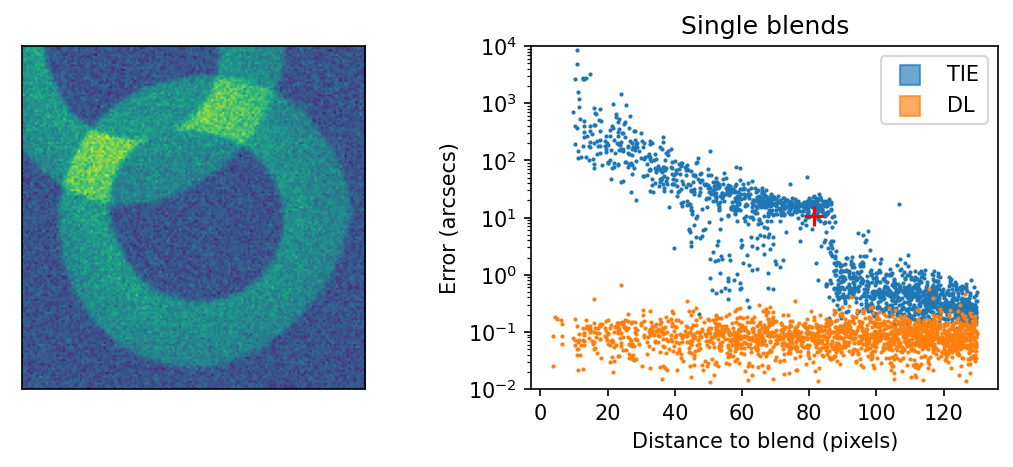

In [279]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150, constrained_layout=True)

data = clean_errs(maxBlends=1, minBrightDist=0)
data = data[data["nBrightBlends"] == 1]

cut = data[
    (data["exp"] > 1.2) & (data["minBrightDist"] > 80) & (data["minBrightDist"] < 88)
]
intraIdx, extraIdx, d, e = cut[["intraIdx", "extraIdx", "minBrightDist", "exp"]].iloc[2]
ax1.imshow(df.loc[intraIdx]["image"], origin="lower")
ax1.set(xticks=[], yticks=[])

ax2.scatter(data["minBrightDist"], data["exp"], s=1, rasterized=True)
ax2.scatter(data["minBrightDist"], data["ml"], s=1, rasterized=True)
ax2.scatter(d, e, marker="+", c="r", lw=1.5, s=100)

ax2.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="TIE")
ax2.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="DL")
ax2.legend()

ax2.set(
    ylim=(1e-2, 1e4),
    yscale="log",
    title="Single blends",
    xlabel="Distance to blend (pixels)",
    ylabel="Error (arcsecs)",
)

fig.savefig("figures/blend_dist_scatter.pdf")
plt.show()


## 8. Faint Blends

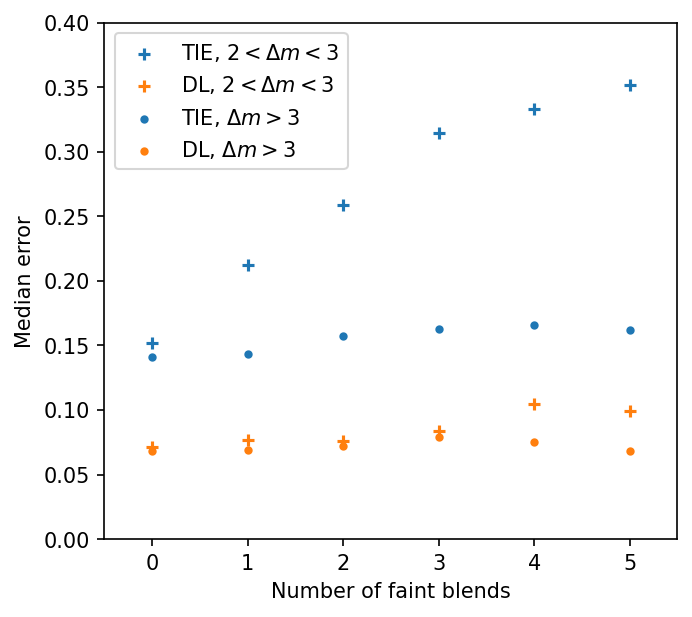

In [76]:
fig, ax = plt.subplots(figsize=(4.5, 4), dpi=150, constrained_layout=True)

data = clean_errs()

# first do the brighter of the faint blends
exp_med_l3 = data.groupby("nFaintBlends<1")["exp"].median()
ml_med_l3 = data.groupby("nFaintBlends<1")["ml"].median()
ax.scatter(
    exp_med_l3.index, exp_med_l3, marker="+", label="TIE, $2 < \Delta m < 3$", c="C0"
)
ax.scatter(
    ml_med_l3.index, ml_med_l3, marker="+", label="DL, $2 < \Delta m < 3$", c="C1"
)

# now do the fainter of the faint blends
exp_med_g3 = data[data["nFaintBlends<1"] == 0].groupby("nFaintBlends>1")["exp"].median()
ml_med_g3 = data[data["nFaintBlends<1"] == 0].groupby("nFaintBlends>1")["ml"].median()
ax.scatter(
    exp_med_g3.index, exp_med_g3, marker=".", label="TIE, $\Delta m > 3$", c="C0"
)
ax.scatter(ml_med_g3.index, ml_med_g3, marker=".", label="DL, $\Delta m > 3$", c="C1")


ax.set(
    xlabel="Number of faint blends",
    ylabel="Median error",
    xlim=(-0.5, 5.5),
    ylim=(0, 0.4),
)
ax.legend(loc=2)

fig.savefig("figures/faint_blend_scatter.pdf")
plt.show()


## 9. Error per Zernike coefficient

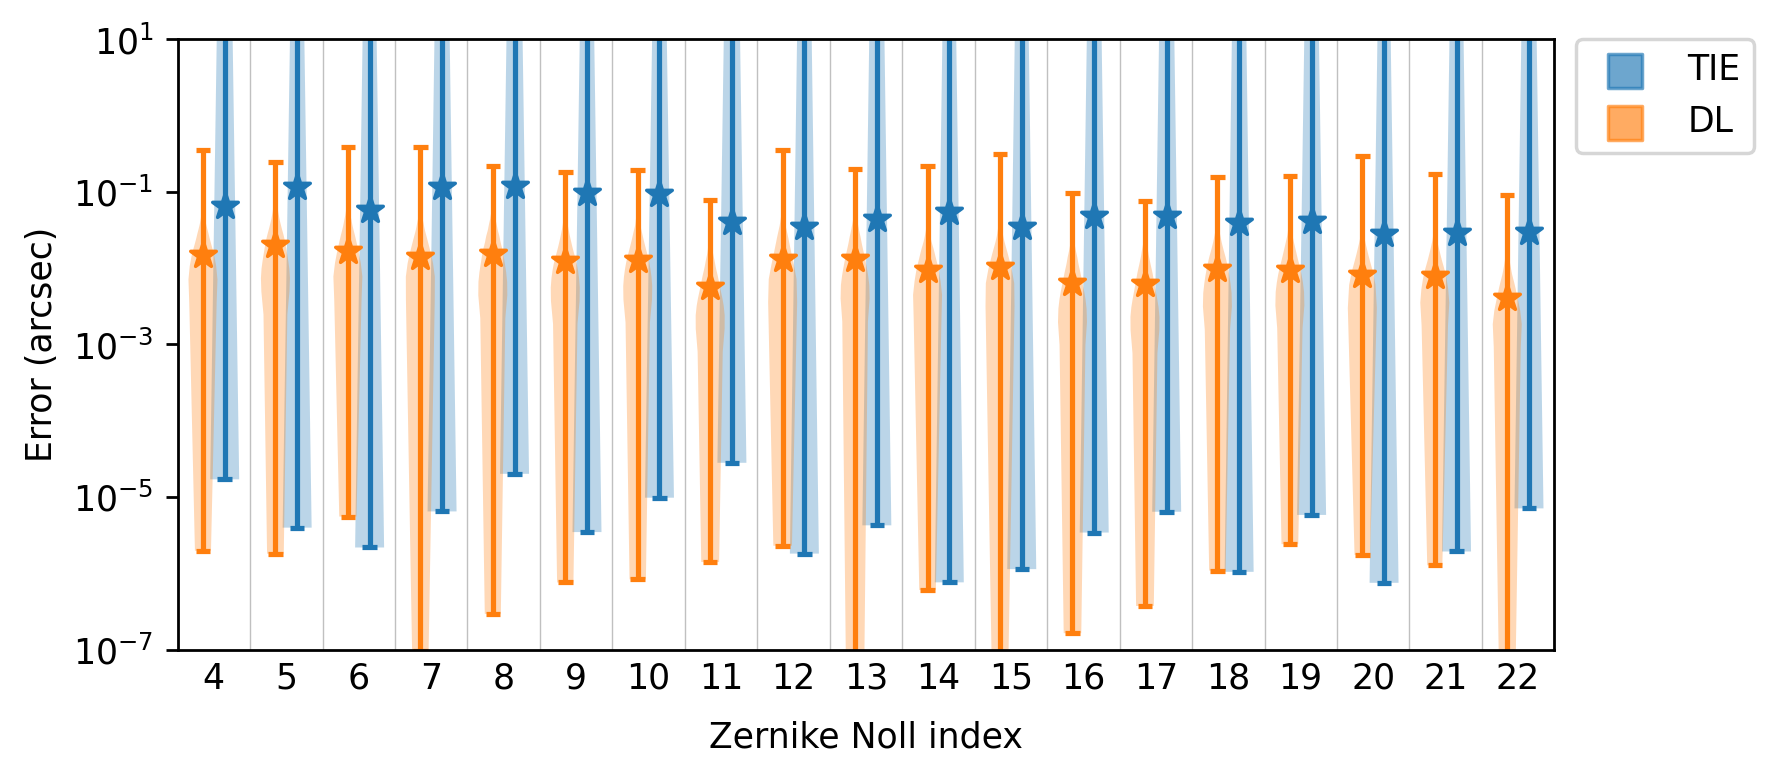

In [32]:
# errors per zernike coefficient
exp_err_by_zk = np.sqrt(np.square(zk["exp"] - zk["truth"]))
ml_err_by_zk = np.sqrt(np.square(zk["ml"] - zk["truth"]))

exp_err_by_zk = exp_err_by_zk[np.all(np.isfinite(exp_err_by_zk), axis=1)]


fig, (ax, leg) = plt.subplots(
    1,
    2,
    figsize=(7, 3),
    dpi=250,
    gridspec_kw={"width_ratios": [8, 1]},
    constrained_layout=True,
)

# create a violin plot of the errors per zernike coefficient
positions = np.arange(4, 23)
ax.violinplot(exp_err_by_zk, positions=positions + 0.15, widths=0.4)
ax.violinplot(ml_err_by_zk, positions=positions - 0.15, widths=0.4)

# plot the medians as stars
ax.scatter(
    positions + 0.15,
    np.median(exp_err_by_zk, axis=0),
    marker="*",
    s=60,
)
ax.scatter(
    positions - 0.15,
    np.median(ml_err_by_zk, axis=0),
    marker="*",
    s=60,
)

# setup labels
ax.set(
    xlabel="Zernike Noll index",
    xticks=positions,
    xlim=(3.5, 22.5),
    ylim=(1e-7, 1e1),
    ylabel="Error (arcsec)",
    yscale="log",
)
ax.xaxis.labelpad = 7
ax.tick_params(axis="x", length=0)

# silver lines between panels
for i in positions[:-1]:
    ax.axvline(i + 0.5, c="silver", ls="-", lw=0.4, zorder=0)

# edges = np.concatenate([[3.5], positions + 0.5])
# for i, e in enumerate(np.median(atm_err_per_zk, axis=0)):
#    ax.plot(edges[i : i + 2], [e, e], c="gray", lw=1, ls="--", alpha=0.8)

# create the legend
leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="TIE")
leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="DL")
leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
leg.axis("off")

fig.savefig("figures/err_per_zernike.pdf")
plt.show()


## Some ratios

In [396]:
data = errs[(errs["nBrightBlends"] == 0) & (errs["vignetting"] == "Camera vignetting")]
data["exp"].median() / data["ml"].median()


4.876058026604508

In [398]:
data = errs[(errs["nBrightBlends"] == 1) & (errs["vignetting"] == "Mirror vignetting")]
data["exp"].median() / data["ml"].median()


319.24907016055204

In [8]:
atm_errs = np.load("data/atm_errs.npy")


In [9]:
atm_errs.shape


(10000, 19)